# Tutorial: Getting your first bias corrections with bmorph
This notebook demonstrates how to setup data for and bias correct it through **bmorph**, it contains the same information as the [tutorial](bmorph_tutorial.rst) page.
In this notebook, we will demonstrate how to perform four variations of bias correction.

* Independent Bias Correction: Univariate (IBC_U) : IBC_U is the traditional bias correction method. This method can only be performed at sites with reference data.
* Independent Bias Correction: Conditioned (IBC_C) : IBC_C allows for correcting for specific biases that are process-dependent. This method can only be performed at sites with reference data.
* Spatially Consistent Bias Correction: Univariate (SCBC_U): SCBC_U corrects local flows at each river reach in the network, and then reroutes them to aggregate, producing bias corrected flows everywhere.
* Spatially Consistent Bias Correction: Conditioned (SCBC_C): SCBC_C also corrects the local flows like SCBC_U, but allows for conditioning on dependent processes.

## Import Packages and Load Data

We start by importing the necessary packages for the notebook.
This notebook mainly shows how to use ``bmorph.core.workflows`` and ``bmorph.core.mizuroute_utils`` to bias correct streamflow data in the Yakima river basin.

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from dask.distributed import Client, progress

# Set a bigger default plot size
mpl.rcParams['figure.figsize'] = (10, 8)

# Import bmorph, and mizuroute utilities
import bmorph
from bmorph.util import mizuroute_utils as mizutil
from bmorph.evaluation import plotting as bplot

# Set the environment directory, this is a workaround for portability
envdir = os.path.dirname(sys.executable)

# Import pyproj and set the data directory, this is a workaround for portability
import pyproj
pyproj.datadir.set_data_dir(f'{envdir}/../share/proj')

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting mizuroute and sample data

The following code cell has three commands preceded by `!`, which indicates that they are shell command. The first command will install mizuroute into the environment. The second two will download the sample data and unpackage it. The sample data can be viewed as a HydroShare resource [here](https://www.hydroshare.org/resource/fd2a347d34f145b4bfa8b6bff39c782b/). This cell may take a few moments.

In [5]:
#! conda install -c conda-forge mizuroute -y
! wget https://www.hydroshare.org/resource/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.gz
! tar xvf bmorph_testdata.tar.gz

--2021-04-14 17:51:15--  https://www.hydroshare.org/resource/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.gz
Resolving www.hydroshare.org (www.hydroshare.org)... 152.54.2.89
Connecting to www.hydroshare.org (www.hydroshare.org)|152.54.2.89|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /resource/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.gz/ [following]
--2021-04-14 17:51:16--  https://www.hydroshare.org/resource/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.gz/
Reusing existing connection to www.hydroshare.org:443.
HTTP request sent, awaiting response... 302 Found
Location: /django_irods/rest_download/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.gz/?url_download=False&zipped=False&aggregation=False [following]
--2021-04-14 17:51:16--  https://www.hydroshare.org/django_irods/rest_download/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.

## Sample data study site: the Yakima river basin

Before getting into how to run bmorph, let's look at what is in the sample data. You will note that we now have a `yakima_workflow` directory. This contains all of the data that you need to run the tutorial. There are a few subdirectories:

 * `gis_data`: contains shapefiles, this is mainly used for plotting, not for analysis
 * `input`: this is the input meteorologic data, simulated streamflow to be corrected, and the reference flow dataset
 * `mizuroute_configs`: this is an empty directory that will automatically be populated with mizuroute configuration files during the bias correction process
 * `output`: this is an empty directory that will be where the bias corrected flows will be written out to
 * `topologies`: this contains the stream network topologies that will be used for routing flows via mizuroute
 
The Yakima river basin is a tributary of the Columbia river basin in the Pacific northwestern United States. It's western half is situated in the Cascade mountains and receives seasonal snowpack. The eastern half is lower elevation and is semi-arid. Let's load up the shapefiles for the sub-basins and stream network and plot it. In this discretization we have 285 sub-basins (HRU) and 143 stream segments.

/pool0/home/steinjao/.conda/envs/project/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/pool0/home/steinjao/.conda/envs/project/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Text(56.75, 0.5, 'Latitude')

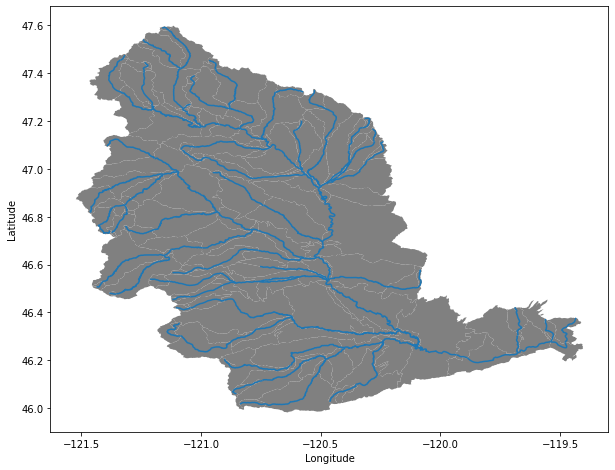

In [6]:
yakima_hru = gpd.read_file('./yakima_workflow/gis_data/yakima_hru.shp').to_crs("EPSG:4326")
yakima_seg = gpd.read_file('./yakima_workflow/gis_data/yakima_seg.shp').to_crs("EPSG:4326")

ax = yakima_hru.plot(color='grey')
yakima_seg.plot(ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

## Setting up some metadata

Next you provide the gauge site names and their respective river segment identification
numbers, or ``site``'s and ``seg``'s. This will be used throughout to ensure the data does
not get mismatched. 

bmorph uses the convention:
`site_to_seg = { site_0_name : site_0_seg, ..., site_n_name, site_n_seg}`

In [7]:
site_to_seg = {'KEE' : 4175, 'KAC' : 4171, 'EASW': 4170, 
               'CLE' : 4164, 'YUMW': 4162, 'BUM' : 5231,
               'AMRW': 5228,  'CLFW': 5224,  'RIM' : 5240,
               'NACW': 5222, 'UMTW': 4139,  'AUGW': 594,  
               'PARW': 588,   'YGVW': 584,   'KIOW': 581}

Since it is convenient to be able to access this data in different orders we also set up 
some other useful forms of these gauge site mappings for later use.

In [8]:
seg_to_site = {seg: site for site, seg in site_to_seg.items()}
ref_sites = list(site_to_seg.keys())
ref_segs = list(site_to_seg.values())    

Next we load in stream network topology (topo), meteorlogical data (met), 
uncorrected flows (raw), and reference flows (ref). 
A description of how your project directory is expected to be set up can be found in [the documentation](https://bmorph.readthedocs.io/en/develop/data.html).

In [9]:
yakima_topo = xr.open_dataset('yakima_workflow/topologies/yakima_huc12_topology.nc').load()

Here we load in some example meteorological data that will be used for conditional bias correction: daily minimum temperature (`tmin`), seasonal precipitation (`prec`),
and daily maximum temperature (`tmax`). In principle, any type of data can be used for conditioning.

In [10]:
yakima_met = xr.open_dataset('yakima_workflow/input/yakima_met.nc').load()
yakima_met['hru'] = (yakima_met['hru'] - 1.7e7).astype(np.int32)

Finally, we load the simulated flows and reference flows. 
bmorph is designed to bias correct streamflow simulated with [mizuroute](https://mizuroute.readthedocs.io/en/latest/). 
We denote the simulated flows as the "raw" flows when they are uncorrected, and the flows that will be used to correct the raw flows as the reference flows. 
In our case the reference flows are estimated no-reservoir-no-irrigation (NRNI) flows taken from the [River Management Joint Operating Committee (RMJOC)](https://www.bpa.gov/p/Generation/Hydro/Documents/RMJOC-II_Part_II.PDF).

In [11]:
# Raw flows
yakima_raw = xr.open_dataset('yakima_workflow/input/yakima_raw_flows.nc')[['IRFroutedRunoff', 'dlayRunoff', 'reachID']].load()
# Update some metadata
yakima_raw['seg'] = yakima_raw.isel(time=0)['reachID'].astype(np.int32)

# Reference flows - this contains sites from the entire Columbia river basin
yakima_ref = xr.open_dataset('yakima_workflow/input/nrni_reference_flows.nc').rename({'outlet':'site'})[['seg', 'seg_id', 'reference_flow']]
# Pull out only the sites in the Yakima basin
yakima_ref = yakima_ref.sel(site=ref_sites).load()

## Convert from ``mizuroute`` output to ``bmorph`` format

``mizuroute_utils`` is our utility module that will handle converting mizuroute outputs to the format that we need for ``bmorph``. 
We will use the `mizutil.to_bmorph` function to merge together all of the data we previously loaded, and calculate some extra pieces of information to perform spatially consistent bias corrections (SCBC).
For more information about how we perform SCBC see [the SCBC page in the documentation](https://bmorph.readthedocs.io/en/develop/bias_correction.html#spatial-consistency-reference-site-selection-cdf-blend-factor).
Now we pass our data in to ``to_bmorph``, the primary utility function for automating ``bmorph`` pre-procesing.

In [12]:
yakima_met_seg = mizutil.to_bmorph(yakima_topo, yakima_raw, yakima_ref, yakima_met,  fill_method='r2')

## Setting up ``bmorph`` configuration and parameters

Before applying bias correction we need to specify some parameters and configuration
for correction. Returning to these steps can help fine tune your bias 
corrections to the basin you are analyzing.

The ``train_window`` is what we will use to train the bias correction
model. This is the time range that is representative of the
basin's expected behavior that ``bmorph`` should mirror.

The ``bmorph_window`` is when ``bmorph`` should be applied to the series for
bias correction.

Lastly the ``reference_window`` is when the reference flows should be used to 
smooth the bias corrected flows. This is recommended to be set as equivalent to the
``train_window``.

In [13]:
train_window = pd.date_range('1981-01-01', '1990-12-30')[[0, -1]]
bmorph_window = pd.date_range('1991-01-01', '2005-12-30')[[0, -1]]
reference_window = train_window

``interval`` is the length of ``bmorph``'s application intervals, 
typically a factor of years to preserve hydrologic 
relationships. Note that for ``pandas.DateOffset``, 'year' and 'years' 
are different and an 's' should always be included here for ``bmorph``
to run properly, even for a single year.

``overlap`` describes how many days the bias correction cumulative distribution function
windows should overlap in total with each other. ``overlap`` is evenly distributed before
and after this window. This is used to reduce discontinuities between application periods.

``condition_var`` names the variable to use in conditioning, such as maximum
temperature (tmax), seasonal precipitation (seasonal_precip), or daily
minimum temperature (tmin). At this time, only one conditioning
meteorological variable can be used per ``bmorph`` execution. In this example,
``tmax`` and ``seasonal_precip`` have been commented out to select ``tmin`` as
the conditioning variable. If you wish to change this, be sure to either change
which variables are commented out or change the value of ``condition_var`` itself.

In [14]:
interval = pd.DateOffset(years=1)
overlap = 90

# Select from the various available meteorologic fields for conditioning
#condition_var = 'tmax'
#condition_var = 'seasonal_precip'
condition_var = 'tmin'

Here we name some configuration parameters for ``bmorph``'s conditional and univariate
bias correction methods, respectively. 

``output_prefix`` will be used to write and load files according to the
basin's name, make certain to update this with the actual name of
the basin you are analyzing so you can track where different files
are written.

In [15]:
conditonal_config = {
    'data_path':  './yakima_workflow',
    'output_prefix': "yakima",
    'train_window': train_window,
    'bmorph_window': bmorph_window,
    'reference_window': reference_window,
    'bmorph_interval': interval,
    'bmorph_overlap': overlap,
    'condition_var': condition_var
}

univariate_config = {
    'data_path':  './yakima_workflow',
    'output_prefix': "yakima",
    'train_window': train_window,
    'bmorph_window': bmorph_window,
    'reference_window': reference_window,
    'bmorph_interval': interval,
    'bmorph_overlap': overlap,
}

You made it! Now we can actually bias correction with ``bmorph``! 

First off we run the Independent Bias Corrections, which are completely contained
in the cell below. 

Here we run through each of the gauge sites and correct them 
individually. Since independent bias correction can only be performed
at locations with reference data, corrections are only performed at
the gauge sites here. 

## Independent bias correction

In [16]:
ibc_u_flows = {}
ibc_u_mults = {}
ibc_c_flows = {}
ibc_c_mults = {}

raw_flows = {}
ref_flows = {}
for site, seg in tqdm(site_to_seg.items()):
    raw_ts =   yakima_met_seg.sel(seg=seg)['IRFroutedRunoff'].to_series()
    train_ts = yakima_met_seg.sel(seg=seg)['IRFroutedRunoff'].to_series()
    obs_ts =   yakima_met_seg.sel(seg=seg)['up_ref_flow'].to_series()
    cond_var = yakima_met_seg.sel(seg=seg)[f'up_{condition_var}'].to_series()
    ref_flows[site] = obs_ts
    raw_flows[site] = raw_ts

    ## IBC_U (Independent Bias Correction: Univariate)
    ibc_u_flows[site], ibc_u_mults[site] = bmorph.workflows.apply_interval_bmorph(
        raw_ts, train_ts, obs_ts, train_window, bmorph_window, reference_window, interval, overlap)

    ## IBC_C (Independent Bias Correction: Conditioned)
    ibc_c_flows[site], ibc_c_mults[site] = bmorph.workflows.apply_interval_bmorph(
        raw_ts, train_ts, obs_ts, train_window, bmorph_window, reference_window, interval, overlap,
        raw_y=cond_var, train_y=cond_var, obs_y=cond_var)

## Spatially consistent bias correction


Here we specify where the ``mizuroute`` executable is installed on your system.

In [17]:
mizuroute_exe = f'{envdir}/route_runoff.exe'

Now we use ``run_parallel_scbc`` to do the rest. 
The next two cells may each take up to 3 minutes to run.
In the first cell we will run the spatially-consistent bias correction without any conditioning. 
The second cell will run the spatially-consistent bias correction with conditioning.
This produced bias corrected flows at all 143 stream segments in the Yakima river basin.
Finally, we select out the corrected streamflows for both cases (with and without conditioning) to only contain the gauged sites.
Selecting out only the gauged locations allows us to compare the spatially-consistent methods with the independent bias corrections.
Finally we combine all the data into a single xarray `Dataset` to make analysis easier.

In [25]:
#xr.set_options(display_style='html')
xr.open_dataset('./yakima_workflow/input/yakima_local_conditional_scbc.nc')

<xarray.Dataset>
Dimensions:    (seg: 143, time: 5480)
Coordinates:
  * seg        (seg) float64 580.0 581.0 582.0 ... 5.245e+03 5.246e+03 5.247e+03
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 2006-01-01
Data variables:
    scbc_flow  (time, seg) float64 ...

In [18]:
# SCBC without conditioning
unconditioned_seg_totals = bmorph.workflows.run_parallel_scbc(yakima_met_seg, mizuroute_exe, univariate_config)

OSError: no files to open

In [23]:
# SCBC with conditioning
conditioned_seg_totals = bmorph.workflows.run_parallel_scbc(yakima_met_seg, mizuroute_exe, conditonal_config)

OSError: no files to open

In [ ]:
# Here we select out our rerouted gauge site modeled flows.
unconditioned_site_totals = {}
conditioned_site_totals = {}
for site, seg in tqdm(site_to_seg.items()):
    unconditioned_site_totals[site] = unconditioned_seg_totals['IRFroutedRunoff'].sel(seg=seg).to_series()
    conditioned_site_totals[site] = conditioned_seg_totals['IRFroutedRunoff'].sel(seg=seg).to_series()

In [ ]:
# Merge everything together
yakima_analysis = xr.Dataset(coords={'site': list(site_to_seg.keys()), 'time': scbc_c['time']})
yakima_analysis['scbc_c'] = bmorph.workflows.bmorph_to_dataarray(conditioned_site_totals, 'scbc_c')
yakima_analysis['scbc_u'] = bmorph.workflows.bmorph_to_dataarray(unconditioned_site_totals, 'scbc_u')
yakima_analysis['ibc_u'] = bmorph.workflows.bmorph_to_dataarray(ibc_u_flows, 'ibc_u')
yakima_analysis['ibc_c'] = bmorph.workflows.bmorph_to_dataarray(ibc_c_flows, 'ibc_c')
yakima_analysis['raw'] = bmorph.workflows.bmorph_to_dataarray(raw_flows, 'raw')
yakima_analysis['ref'] = bmorph.workflows.bmorph_to_dataarray(ref_flows, 'ref')
yakima_analysis.to_netcdf(f'./yakima_workflow/output/{univariate_config["output_prefix"]}_data_processed.nc')

## Now let's take a look at our results

If you look closely, the following plots are the same ones included in [Plotting](evaluation.rst/Plotting)! Because the plotting functions expect the variable `seg`, we will need to conflate `site` and `seg` for them to properly run.

In [ ]:
yakima_ds = xr.open_dataset(f'yakima_workflow/output/{univariate_config["output_prefix"]}_data_processed.nc')
yakima_ds = yakima_ds.rename({'site':'seg'})

Let's pick a few sites and colors to plot for consistency. To simplify our plots, we will only focus on `scbc_c` in the dataset we just created. The methods do allow for multiple methods to be compared at once however, so we will still need to store the singular `scbc_c` in a list.

Feel free to mess around with the parameters of any of these plots. You can plot more sites if desired, or more methods, just make certain arguments properly line up.

In [ ]:
select_sites = ['KIOW','YUMW','BUM']
select_sites_2 = ['KIOW','YUMW','BUM','KEE']
bcs = ['scbc_c', 'scbc_u', 'ibc_c', 'ibc_u']
colors = ['grey', 'black', 'red', 'orange', 'purple', 'blue']

### Scatter

In [ ]:
plotting.compare_correction_scatter(
    flow_dataset= yakima_ds, 
    plot_sites = select_sites,
    raw_var = 'raw', 
    ref_var = 'ref', 
    bc_vars = bcs, 
    bc_names = [bc.upper() for bc in bcs],
    plot_colors = list(colors[2:]),
    pos_cone_guide = True,
    neg_cone_guide = True,
    symmetry = False,
    title = '',
    fontsize_legend = 120,
    alpha = 0.3
)

### Time Series

In [ ]:
bplot.plot_reduced_flows(
    flow_dataset= yakima_ds, 
    plot_sites = select_sites_2, 
    interval = 'month',
    raw_var = 'raw', raw_name = "Uncorrected",
    ref_var = 'ref', ref_name = "Reference",
    bc_vars = bcs, bc_names = [bc.upper() for bc in bcs],
    plot_colors = colors
);

### Probabilitiy Distribtutions

In [ ]:
bplot.compare_mean_grouped_CPD(
    flow_dataset= yakima_ds, 
    plot_sites = select_sites,
    grouper_func = plotting.calc_water_year, 
    figsize = (60,40),
    raw_var = 'raw', raw_name = 'Uncorrected',
    ref_var = 'ref', ref_name = 'Reference',
    bc_vars = bcs, bc_names = [bc.upper() for bc in bcs],
    plot_colors = colors,
    linestyles = 2 * ['-','-','-'],
    markers = ['o', 'X', 'o', 'o', 'o', 'o'],
    fontsize_legend = 90,
    legend_bbox_to_anchor = (1.9,1.0)
);

### Box & Whisker

In [ ]:
bplot.kl_divergence_annual_compare(
    flow_dataset= yakima_ds, 
    sites = select_sites,
    fontsize_legend = 60, title = '',
    raw_var = 'raw', raw_name = 'Uncorrected',
    ref_var = 'ref', ref_name = 'Reference',
    bc_vars = bcs, bc_names = [bc.upper() for bc in bcs],
    plot_colors = ['grey','red', 'orange', 'purple', 'blue']
);